In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm 
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline


ModuleNotFoundError: No module named 'imblearn'

In [ ]:
df_logRegr = pd.read_csv('data/df_EDA')
df_logRegr

,person_age,person_education,person_income,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22,3,71948.0,RENT,35000.0,PERSONAL,16.02,0.49,3,561,0,1
1,21,0,12282.0,OWN,1000.0,EDUCATION,11.14,0.08,2,504,1,0
2,25,0,12438.0,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3,635,0,1
3,23,2,79753.0,RENT,35000.0,MEDICAL,15.23,0.44,2,675,0,1
4,24,3,66135.0,RENT,35000.0,MEDICAL,14.27,0.53,4,586,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
38539,27,1,47971.0,RENT,15000.0,MEDICAL,15.66,0.31,3,645,0,1
38540,37,1,65800.0,RENT,9000.0,HOMEIMPROVEMENT,14.07,0.14,11,621,0,1
38541,33,1,56942.0,RENT,2771.0,DEBTCONSOLIDATION,10.02,0.05,10,668,0,1
38542,29,2,33164.0,RENT,12000.0,EDUCATION,13.23,0.36,6,604,0,1


# Encoding

### One-Hot Encoding su Variabili 'person_home_ownershio' e 'loan_amnt'

In [ ]:
df_logRegr = pd.get_dummies(df_logRegr, columns=['person_home_ownership', 'loan_intent'], prefix=['home', 'intent'], drop_first=True)
for column in df_logRegr:
    if df_logRegr[column].dtype == bool:
        df_logRegr[column] = df_logRegr[column].astype(int)

df_logRegr

,person_age,person_education,person_income,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status,home_OWN,home_RENT,intent_EDUCATION,intent_HOMEIMPROVEMENT,intent_MEDICAL,intent_PERSONAL,intent_VENTURE
0,22,3,71948.0,35000.0,16.02,0.49,3,561,0,1,0,1,0,0,0,1,0
1,21,0,12282.0,1000.0,11.14,0.08,2,504,1,0,1,0,1,0,0,0,0
2,25,0,12438.0,5500.0,12.87,0.44,3,635,0,1,0,0,0,0,1,0,0
3,23,2,79753.0,35000.0,15.23,0.44,2,675,0,1,0,1,0,0,1,0,0
4,24,3,66135.0,35000.0,14.27,0.53,4,586,0,1,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38539,27,1,47971.0,15000.0,15.66,0.31,3,645,0,1,0,1,0,0,1,0,0
38540,37,1,65800.0,9000.0,14.07,0.14,11,621,0,1,0,1,0,1,0,0,0
38541,33,1,56942.0,2771.0,10.02,0.05,10,668,0,1,0,1,0,0,0,0,0
38542,29,2,33164.0,12000.0,13.23,0.36,6,604,0,1,0,1,1,0,0,0,0


# Standardizzazione Variabile 'loan_status'

In [ ]:
X_bil = df_logRegr.drop(columns=['loan_status'])
Y_bil = df_logRegr['loan_status']


In [ ]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(class_weight='balanced'))
])
pipeline.fit(X_bil, Y_bil)

Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg', LogisticRegression(class_weight='balanced'))])

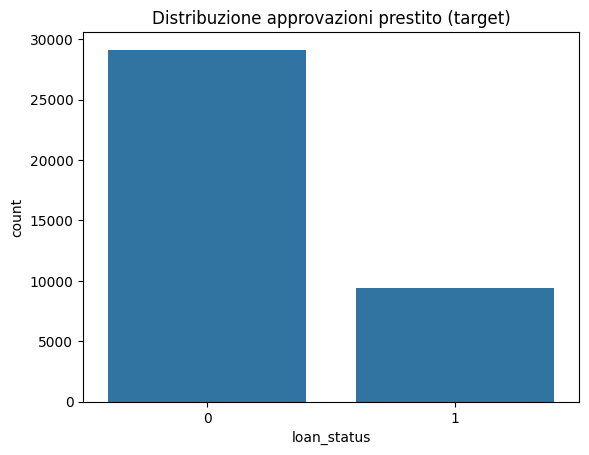

loan_status
0    0.756097
1    0.243903
Name: proportion, dtype: float64


In [ ]:
sns.countplot(x=df_logRegr['loan_status'])
plt.title("Distribuzione approvazioni prestito (target)")
plt.show()
print(df_logRegr['loan_status'].value_counts(normalize=True))